In [2]:
# 0. SETUP

%reload_ext autoreload
%autoreload 3

import pandas as pd
from pathlib import Path
import xarray as xr
import scipy.stats as stats
import numpy as np
from src.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score, learning_curve,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm
from IPython.display import clear_output

from src.acnets.pipeline import Parcellation

tqdm.pandas()

In [3]:
# PARAMETERS

N_CV_SPLITS = 100                       # number of cross-validation splits
N_TEST_SUBJECTS = 8                     # test size for cross-validation (number of subjects)

N_PERMUTATIONS = 10                     # for permutation test

ENABLE_SHAP_ANALYSIS = False            # enable SHAP analysis
ENABLE_LEARNING_CURVE_ANALYSIS = False  # enable learning curves

MODELS_DIR= Path('models/')             # Directory to save models

In [4]:
# DATA PREPARATION
parcellation = Parcellation(atlas_name='dosenbach2010').fit()

subjects = parcellation.dataset_.coords['subject'].values

# extract group labels (AVGP or NVGP) from subject ids (e.g. AVGP-01)
subject_labels = [s[:4] for s in subjects]  

X = subjects.reshape(-1, 1)  # subject ids, shape: (n_subjects, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(subject_labels)     # labels, shape: (n_subjects,)

In [27]:
pipe = ConnectivityPipeline(atlas='dosenbach2010',
                            kind='partial correlation',
                            timeseries_aggregation='network',
                            connectivity_aggregation=None)

pipe.fit_transform(None)
data = pipe.dataset_

avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])


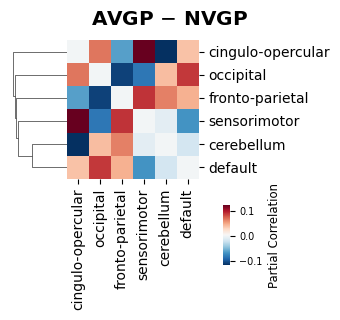

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(data):

    g = sns.clustermap(data, 
                xticklabels=data['network_src'].values,
                yticklabels=data['network_dst'].values,
                figsize=(3.5,3),
                cmap='RdBu_r',
                # col_cluster=False,
                dendrogram_ratio=(.3, 0),
                # move color bar to the right
                cbar_pos=(.65, .2, .02, .2),
                # change color bar font size
                # robust=True,
                # vmin=-.05,
    )
    g.ax_cbar.tick_params(labelsize='x-small')
    g.cax.set_ylabel('Partial Correlation', rotation=90, fontsize='small')

    plt.suptitle('AVGP $-$ NVGP', y=1.05, fontweight='bold', fontsize='x-large')
    plt.show()

diff_avgp_nvgp = avgp['connectivity'].mean('subject') - nvgp['connectivity'].mean('subject')
plot_heatmap(diff_avgp_nvgp)